In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold


In [49]:
#Loading the dataset from the file
df =pd.read_csv('/content/tour_logs_train.csv')
df.head(10)

,Gig_ID,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Merch_Sales_Post_Show,Crowd_Energy
0,Gig_0000,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,916,64.96
1,Gig_0001,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,1003,66.42
2,Gig_0002,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,720,42.58
3,Gig_0003,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0,0.00
4,Gig_0004,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,950,67.55
5,Gig_0005,V_Alpha,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,Cloudy,First Quarter,Denim,914,67.87
6,Gig_0006,V_Gamma,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,Clear,New Moon,Leather,1372,85.45
7,Gig_0007,V_Alpha,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,Cloudy,Waning Crescent,Spandex,1018,66.75
8,Gig_0008,V_Gamma,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,Clear,New Moon,Leather,583,40.85
9,Gig_0009,V_Delta,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,Cloudy,First Quarter,Spandex,551,43.92


In [50]:
#Performing Data Cleaning as Some Data are Not Possible as per scribble txt that capacity is less than 1000 and Crowd Energy cannot be negative and Greater than 100
df['Crowd_Energy'] = df['Crowd_Energy'].apply(lambda x: np.nan if x > 100 or x < 0 else x)
df['Crowd_Size'] = df['Crowd_Size'].apply(lambda x: np.nan if x > 1000 or x < 0 else x)

In [51]:
#as it is data leakage bcoz it is data post show (as will not be available pre show)
#as gig_ID is just a index maintaining record , therefore it is red herrings. So I remove it.
df=df.drop(columns='Merch_Sales_Post_Show')
df=df.drop(columns='Gig_ID')
df.head(10)

,Venue_ID,Show_DateTime,Day_of_Week,Volume_Level,Ticket_Price,Crowd_Size,Opener_Rating,Weather,Moon_Phase,Band_Outfit,Crowd_Energy
0,V_Alpha,2024-03-07 21:00:00,3,5.0,52.93,464.0,2,Rainy,Waning Crescent,Leather,64.96
1,V_Beta,2024-09-05 22:00:00,3,2.0,66.33,388.0,5,Clear,New Moon,Leather,66.42
2,V_Delta,2024-03-09 15:00:00,5,1.0,51.37,679.0,1,Rainy,Waning Crescent,Denim,42.58
3,V_Beta,08/07/2024 08:00 AM,0,10.0,64.77,454.0,1,Rainy,New Moon,Leather,0.00
4,V_Delta,2024-04-26 17:00:00,4,8.0,47.34,654.0,5,Cloudy,Full Moon,Spandex,67.55
5,V_Alpha,2024-09-11 20:00:00,2,3.0,69.63,320.0,4,Cloudy,First Quarter,Denim,67.87
6,V_Gamma,2024-04-09 19:00:00,1,4.0,£54.69,107.0,3,Clear,New Moon,Leather,85.45
7,V_Alpha,2024-06-06 20:00:00,3,2.0,77.17,637.0,3,Cloudy,Waning Crescent,Spandex,66.75
8,V_Gamma,2024-03-12 17:00:00,1,8.0,€44.08,539.0,5,Clear,New Moon,Leather,40.85
9,V_Delta,2024-03-21 19:00:00,3,9.0,43.09,488.0,3,Cloudy,First Quarter,Spandex,43.92


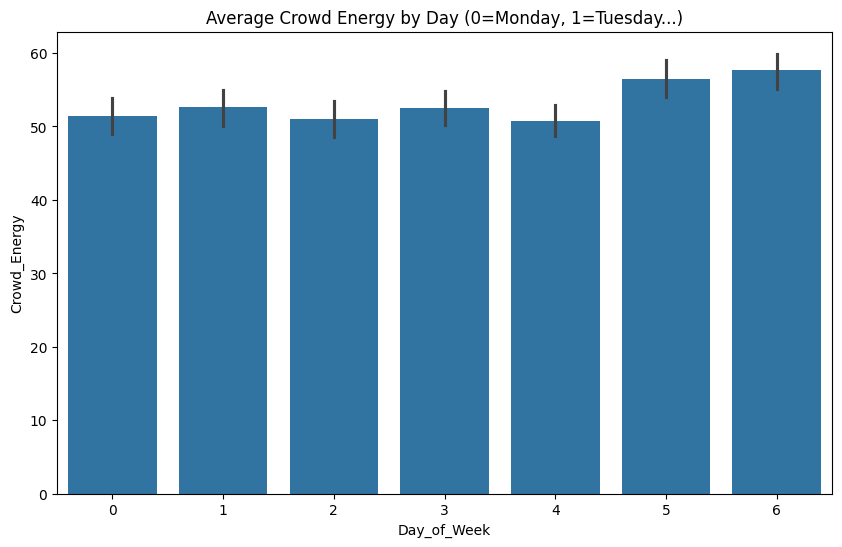

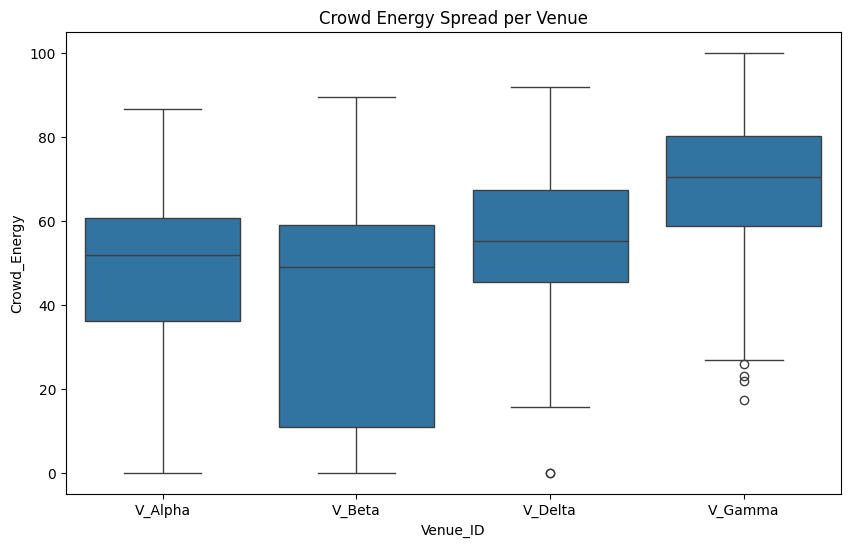

In [52]:
#Exploratory Data Analysis
import seaborn as sns
import matplotlib.pyplot as plt

# Testing the Tuesday Curse
plt.figure(figsize=(10,6))
sns.barplot(x='Day_of_Week', y='Crowd_Energy', data=df)
plt.title('Average Crowd Energy by Day (0=Monday, 1=Tuesday...)')
plt.show()

# Venue- Energy Distribution
plt.figure(figsize=(10,6))
sns.boxplot(x='Venue_ID', y='Crowd_Energy', data=df)
plt.title('Crowd Energy Spread per Venue')
plt.show()



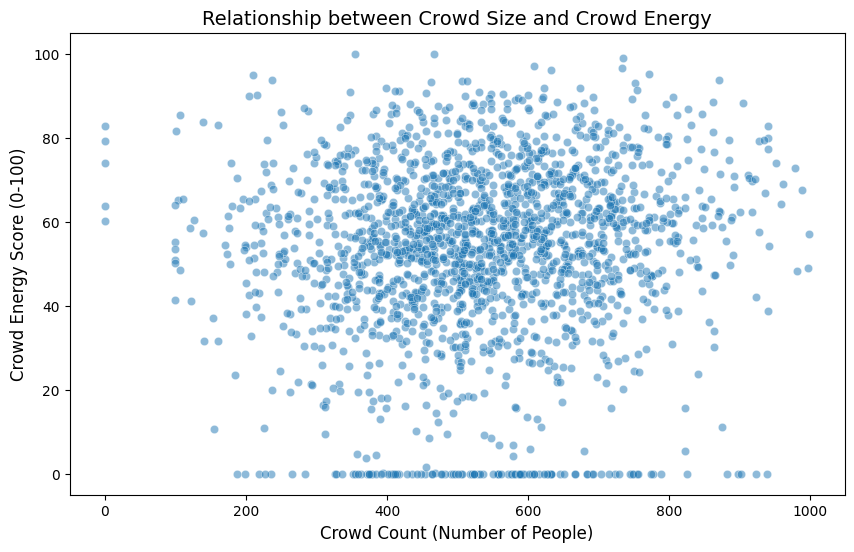

In [53]:
#EDA for Crowd Size VS Crowd Energy
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Crowd_Size', y='Crowd_Energy', alpha=0.5)
plt.title('Relationship between Crowd Size and Crowd Energy', fontsize=14)
plt.xlabel('Crowd Count (Number of People)', fontsize=12)
plt.ylabel('Crowd Energy Score (0-100)', fontsize=12)

plt.show()

<Axes: xlabel='Volume_Level', ylabel='Crowd_Energy'>

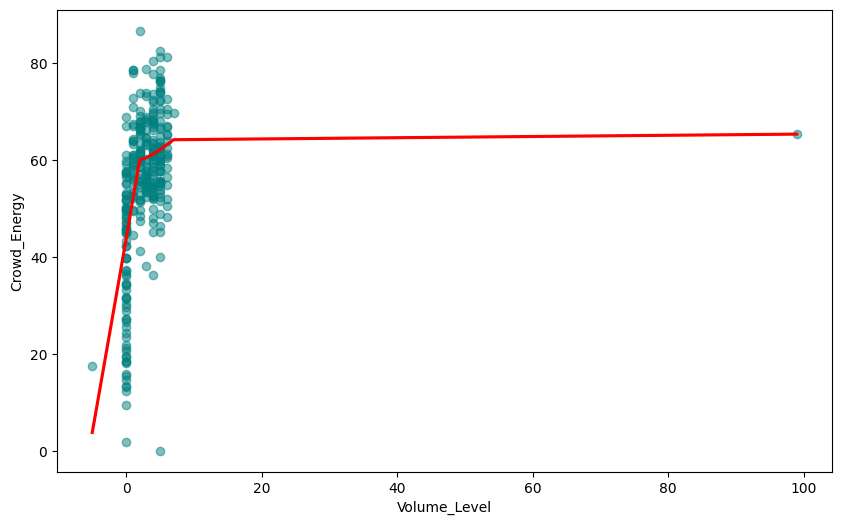

In [54]:
#EDA for Crowd Energy vs Volume Level at V_Alpha
v_alpha_data = df[df['Venue_ID'] == 'V_Alpha']
plt.figure(figsize=(10, 6))
sns.regplot(data=v_alpha_data, x='Volume_Level', y='Crowd_Energy',
    scatter_kws={'alpha':0.5, 'color':'teal'},
    line_kws={'color':'red'},
    lowess=True
)

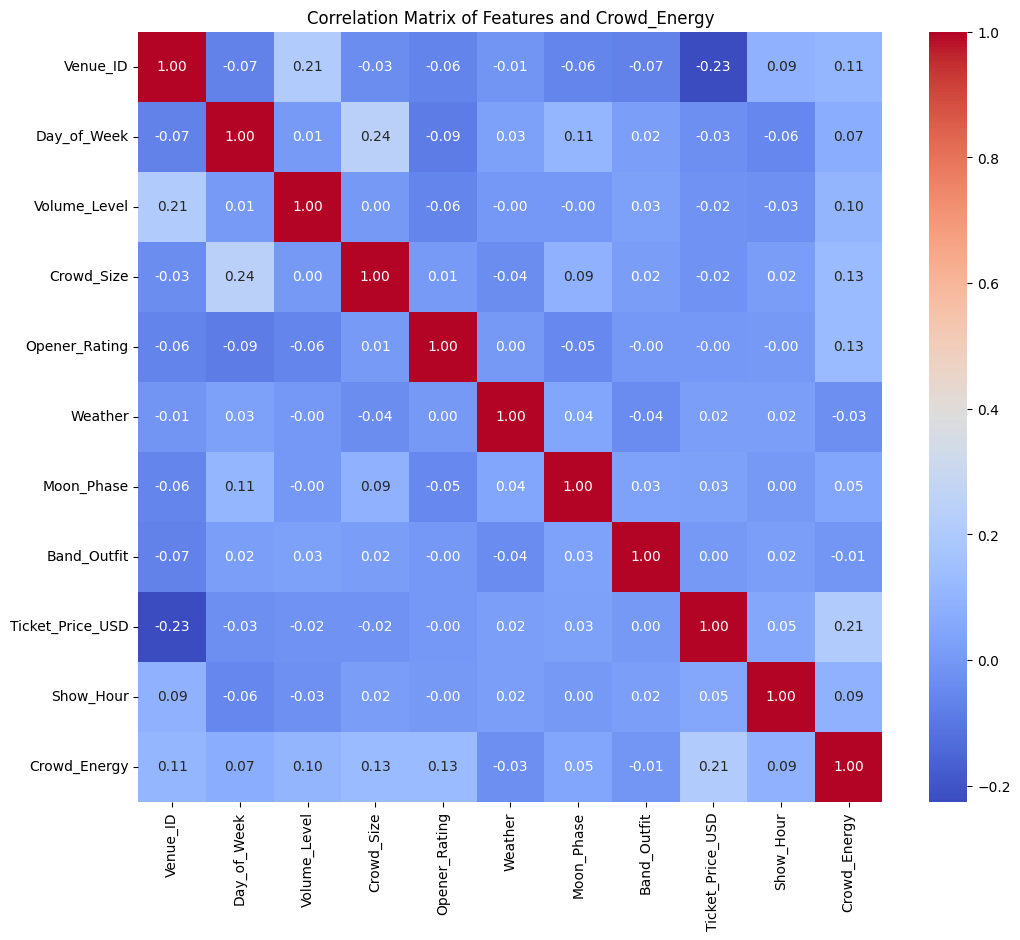

In [55]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features and Crowd_Energy')
plt.show()

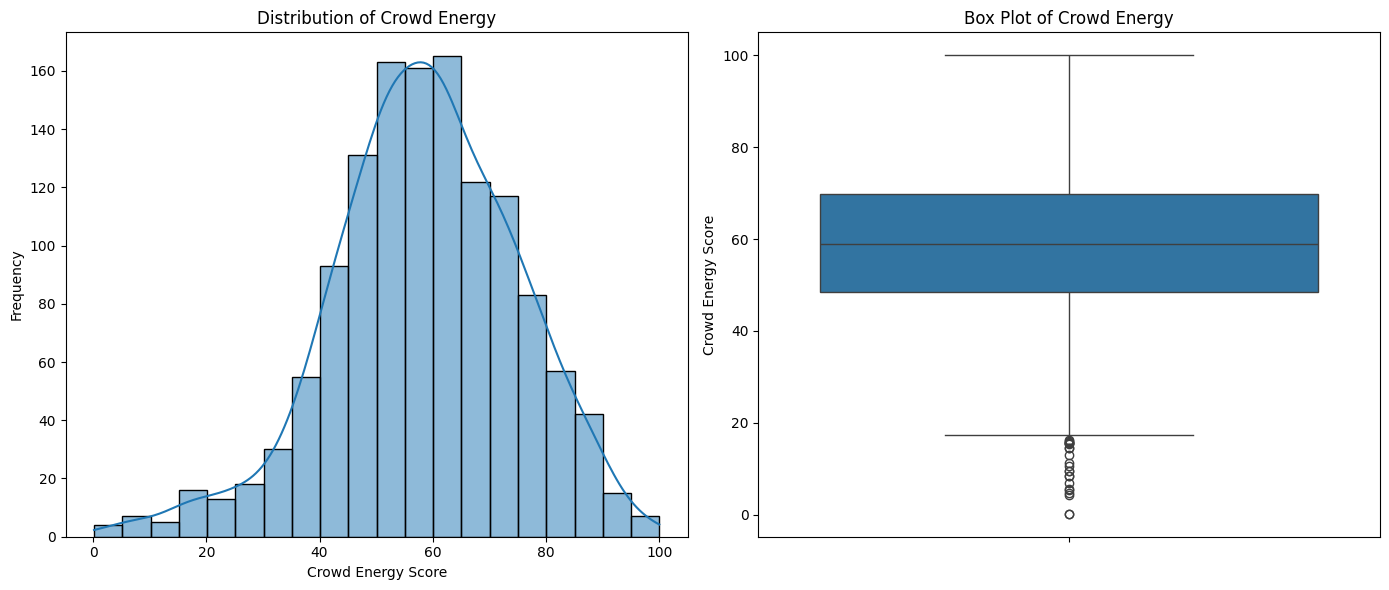

In [56]:
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_train_combined['Crowd_Energy'], bins=20, kde=True)
plt.title('Distribution of Crowd Energy')
plt.xlabel('Crowd Energy Score')
plt.ylabel('Frequency')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=df_train_combined['Crowd_Energy'])
plt.title('Box Plot of Crowd Energy')
plt.ylabel('Crowd Energy Score')

plt.tight_layout()
plt.show()

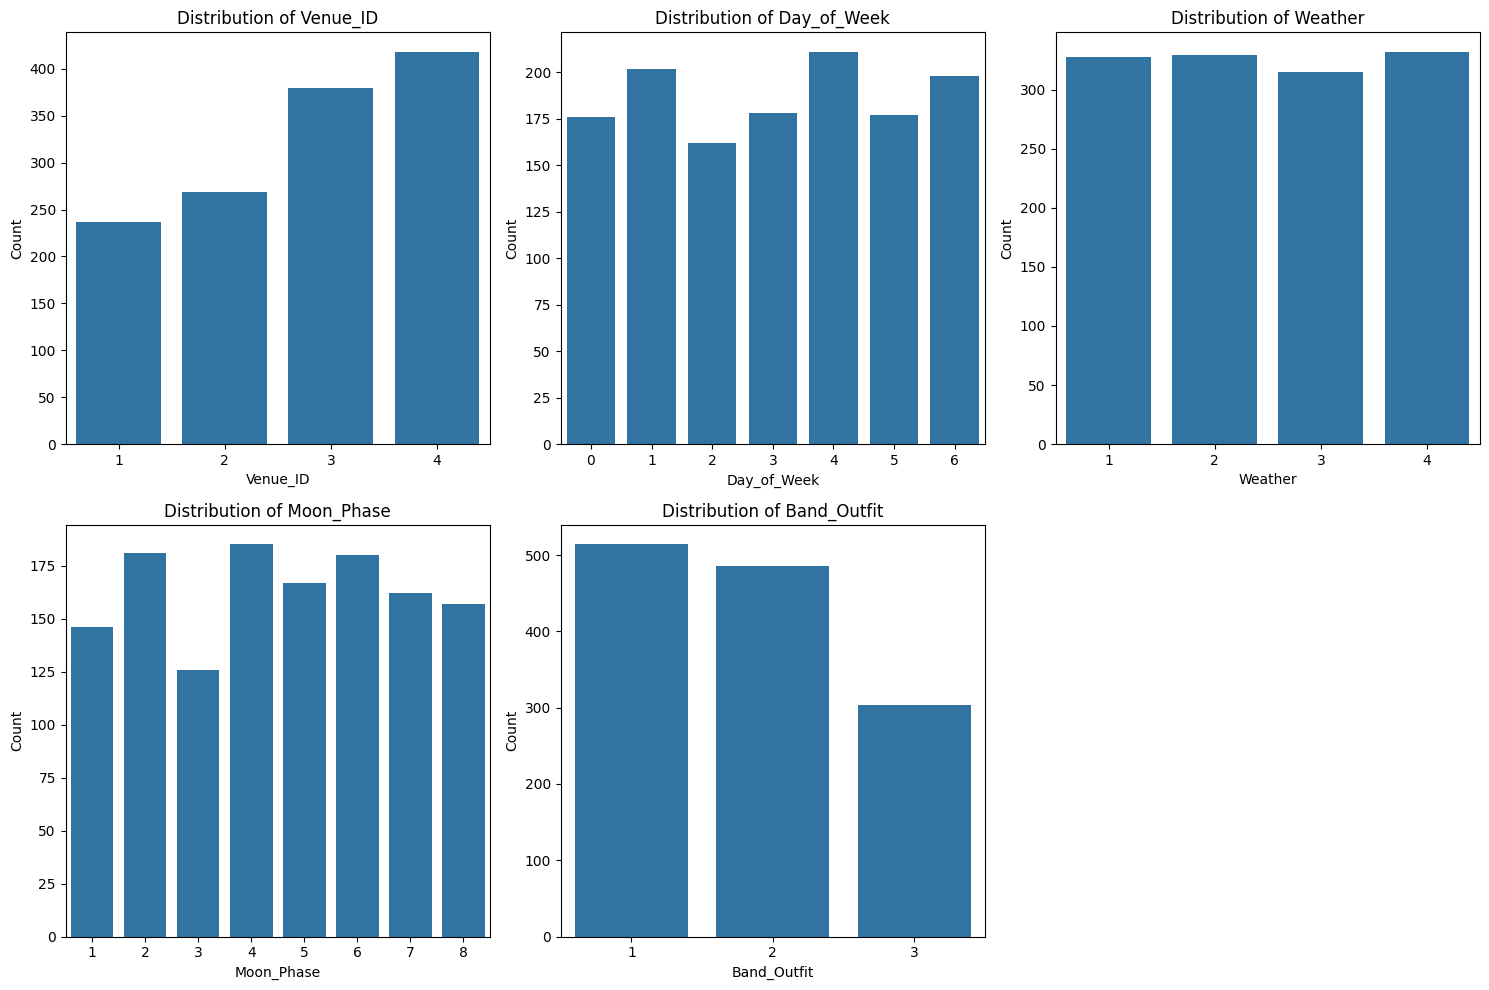

In [57]:
categorical_features = ['Venue_ID', 'Day_of_Week', 'Weather', 'Moon_Phase', 'Band_Outfit']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=df_train_combined[feature])
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

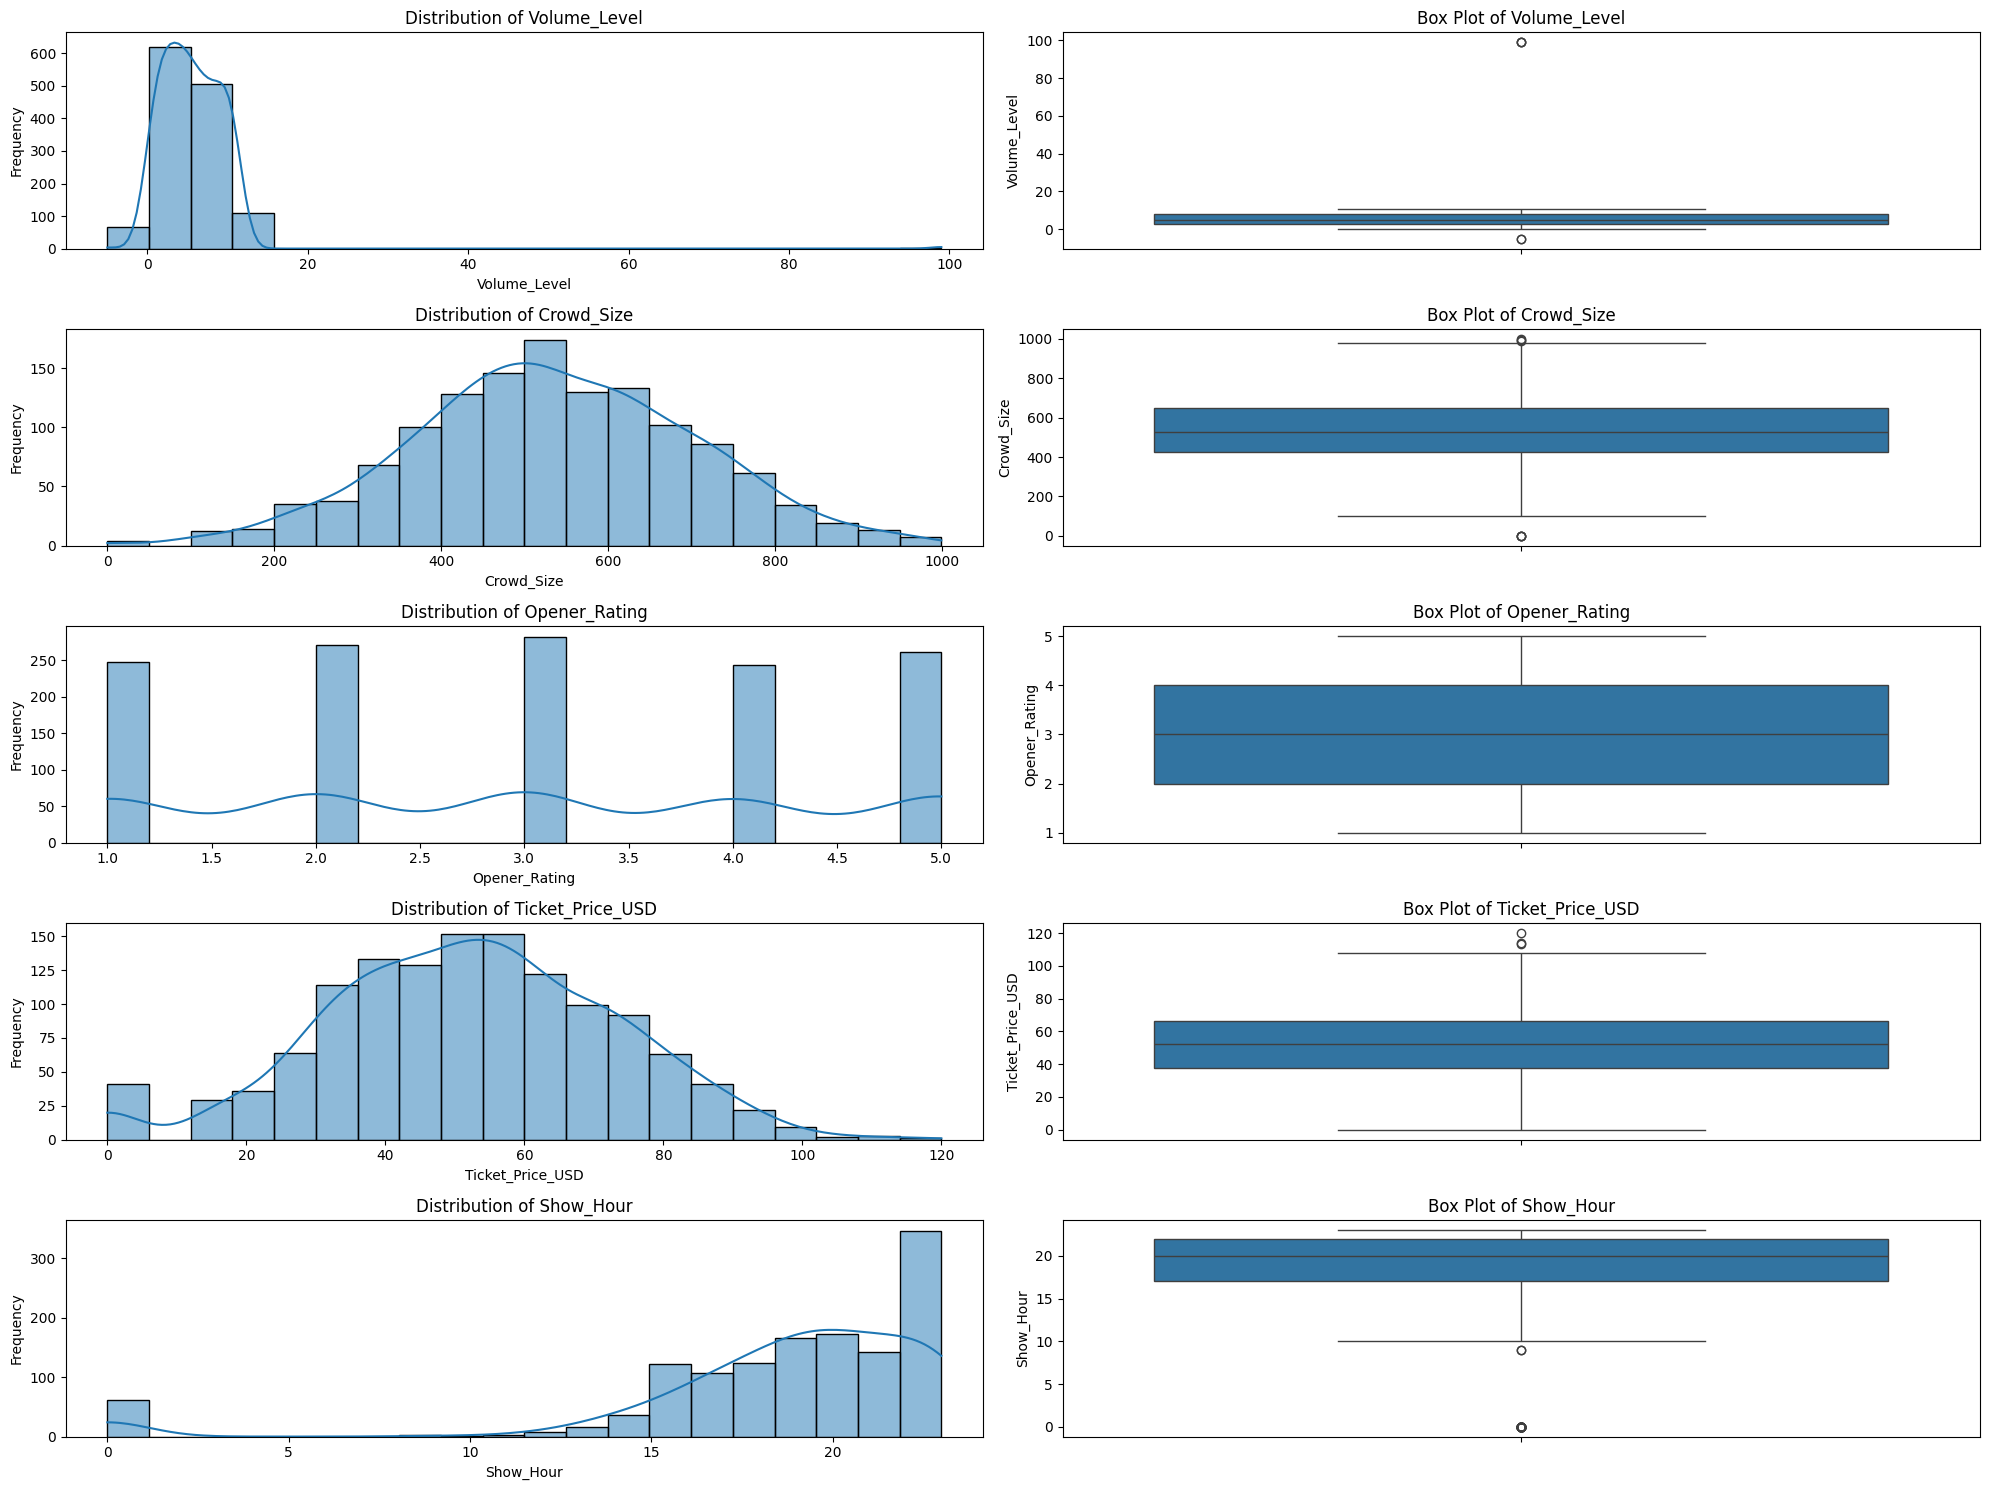

In [58]:
numerical_features = ['Volume_Level', 'Crowd_Size', 'Opener_Rating', 'Ticket_Price_USD', 'Show_Hour']

plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    # Histogram
    plt.subplot(len(numerical_features), 2, 2*i + 1)
    sns.histplot(df_train_combined[feature], bins=20, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Box plot
    plt.subplot(len(numerical_features), 2, 2*i + 2)
    sns.boxplot(y=df_train_combined[feature])
    plt.title(f'Box Plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

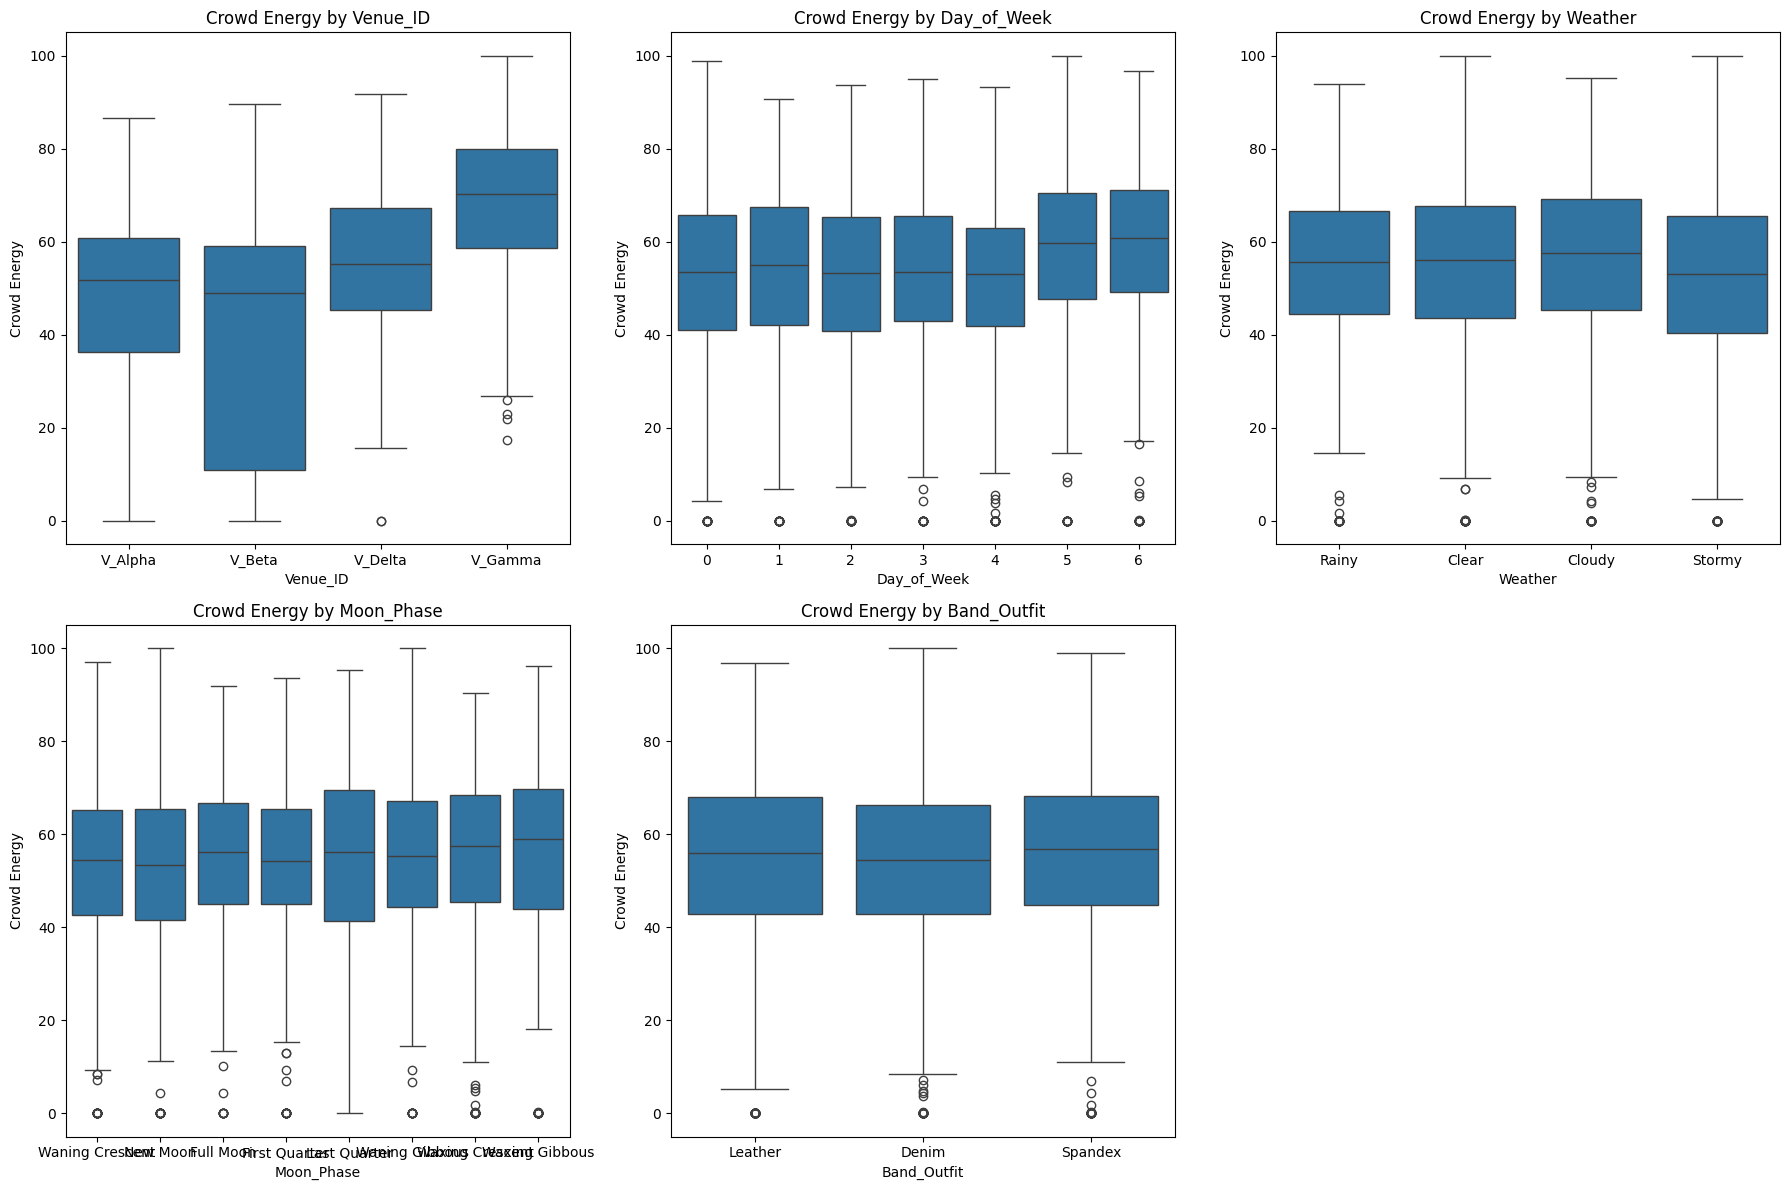

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_features = ['Venue_ID', 'Day_of_Week', 'Weather', 'Moon_Phase', 'Band_Outfit']

plt.figure(figsize=(18, 12))

for i, feature in enumerate(categorical_features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df[feature], y=df['Crowd_Energy'], data=df)
    plt.title(f'Crowd Energy by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Crowd Energy')

plt.tight_layout()
plt.show()